In [145]:
from PIL import Image, ImageChops, ImageFilter, ImageOps
import cv2
import numpy as np

In [146]:
result = Image.open("TEST_1_OUTPUT.png")
init_image = Image.open("TEST_2_STARTING_IMAGE.png")
init_mask = Image.open("TEST_3_STARTING_MASK.png")
mask_blur_radius = 2

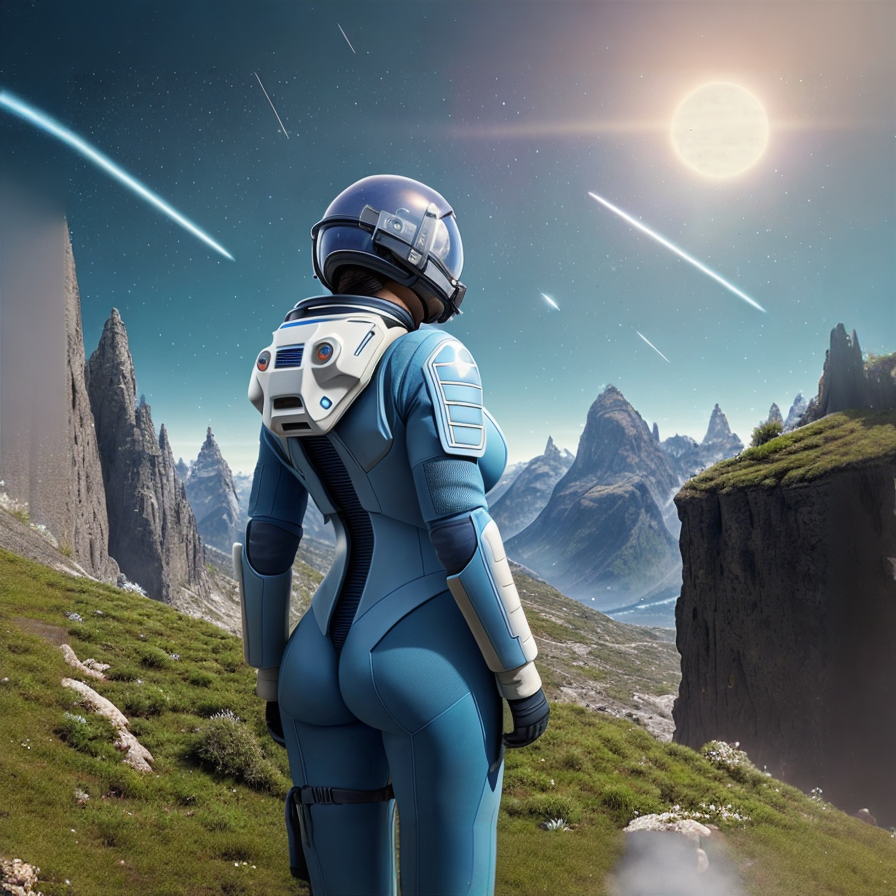

In [147]:
if result.size != init_image.size:
    init_image = init_image.resize(result.size, resample=Image.BICUBIC)
    if init_mask is not None:
        init_mask = init_mask.resize(result.size, resample=Image.BICUBIC)

if init_mask is None:
    init_mask = Image.new('RGB', init_image.size, (0, 0, 0)).convert('L')

# Get the original alpha channel of the mask if there is one.
# Otherwise it is some other black/white image format ('1', 'L' or 'RGB')
pil_init_mask = init_mask.getchannel('A') if init_mask.mode == 'RGBA' else init_mask.convert('L')
pil_init_image = init_image.convert('RGBA')  # Add an alpha channel if one doesn't exist

# Build an image with only visible pixels from source to use as reference for color-matching.
init_rgb_pixels = np.asarray(init_image.convert('RGB'), dtype=np.uint8)
init_a_pixels = np.asarray(pil_init_image.getchannel('A'), dtype=np.uint8)
init_mask_pixels = np.asarray(pil_init_mask, dtype=np.uint8)

# Get numpy version of result
np_image = np.asarray(result, dtype=np.uint8)

# Mask and calculate mean and standard deviation
mask_pixels = init_a_pixels * init_mask_pixels > 0
np_init_rgb_pixels_masked = init_rgb_pixels[mask_pixels, :]
np_image_masked = np_image[mask_pixels, :]

if np_init_rgb_pixels_masked.size > 0:
    init_means = np_init_rgb_pixels_masked.mean(axis=0)
    init_std = np_init_rgb_pixels_masked.std(axis=0)
    gen_means = np_image_masked.mean(axis=0)
    gen_std = np_image_masked.std(axis=0)

    # Color correct
    np_matched_result = np_image.copy()
    np_matched_result[:, :, :] = (((np_matched_result[:, :, :].astype(np.float32) - gen_means[None, None,
                                                                                    :]) / gen_std[None, None,
                                                                                          :]) * init_std[None, None,
                                                                                                :] + init_means[
                                                                                                     None, None,
                                                                                                     :]).clip(0,
                                                                                                              255).astype(np.uint8)
    matched_result = Image.fromarray(np_matched_result, mode='RGB')
else:
    matched_result = Image.fromarray(np_image, mode='RGB')
# Blur the mask out (into init image) by specified amount
if mask_blur_radius > 0:
    nm = np.asarray(pil_init_mask, dtype=np.uint8)
    nmd = cv2.erode(nm, kernel=np.ones((21, 21), dtype=np.uint8), iterations=int(mask_blur_radius / 2))
    pmd = Image.fromarray(nmd, mode='L')
    blurred_init_mask = pmd.filter(ImageFilter.BoxBlur(mask_blur_radius))
else:
    blurred_init_mask = pil_init_mask

split = pil_init_image.split()[-1]
multiplied_blurred_init_mask = ImageChops.multiply(blurred_init_mask, pil_init_image.split()[-1])

rgb_image = init_image
rgb_image.putalpha(blurred_init_mask)
rgb_image = rgb_image.convert("RGBA")

matched_result.paste(rgb_image, (0, 0), mask=blurred_init_mask)
matched_result

In [144]:
matched_result.save("TEST_COMPARE.png")

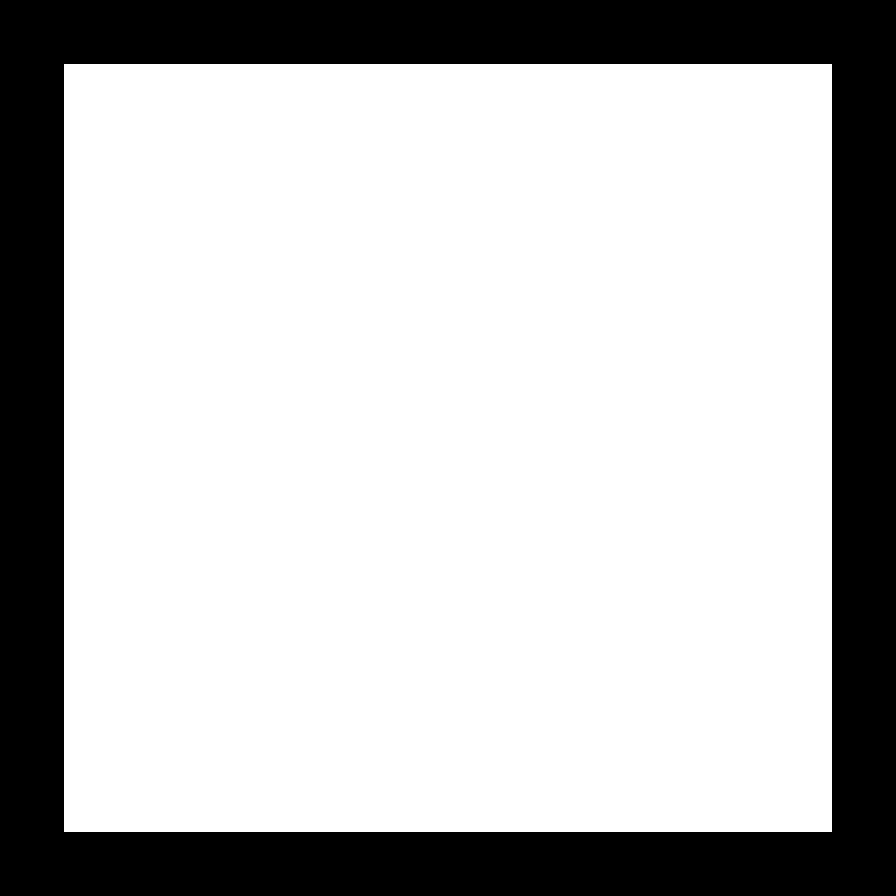

In [130]:
blurred_init_mask

In [124]:
one = ImageChops.multiply(blurred_init_mask, init_image.split()[0])
two = ImageChops.multiply(blurred_init_mask, init_image.split()[1])
three = ImageChops.multiply(blurred_init_mask, init_image.split()[2])

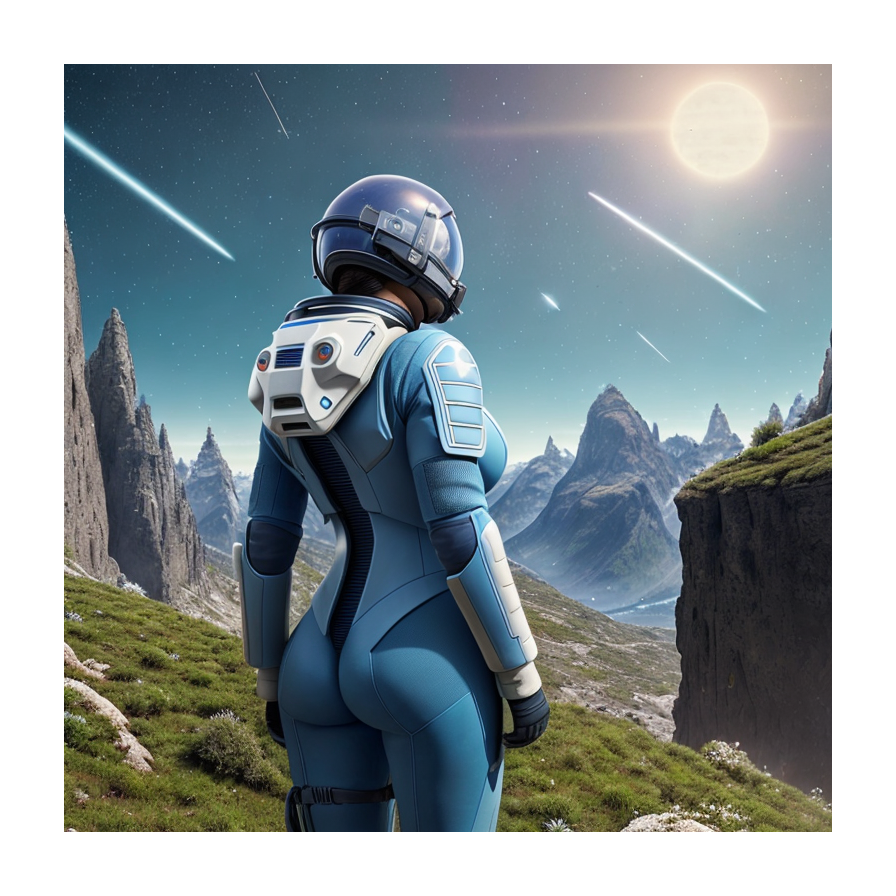

In [125]:
rgb_image = init_image
rgb_image.putalpha(blurred_init_mask)
rgb_image = rgb_image.convert("RGBA")
rgb_image

In [126]:
multiplied_blurred_init_mask = ImageChops.multiply(blurred_init_mask, pil_init_image)

ValueError: images do not match

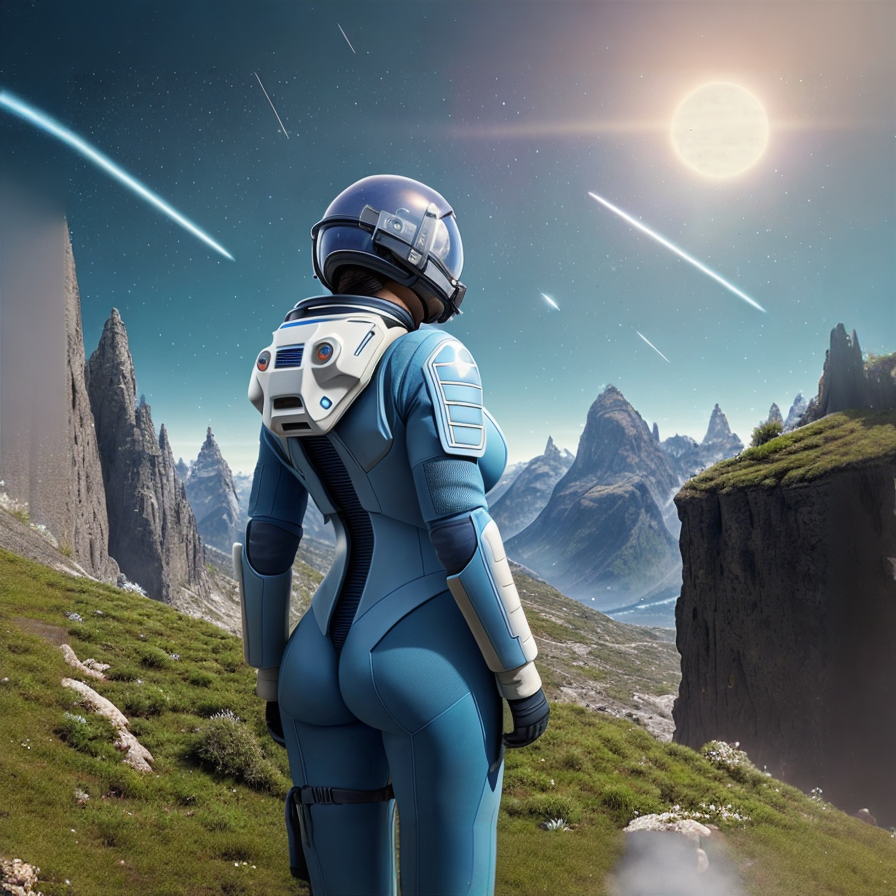

In [116]:
matched_result